In [9]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms #pytorch에 있는 datasets librarary
from torch.optim.lr_scheduler import StepLR

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #gpu 사용 하기 위한 확인 작업
print(device)

cuda


In [11]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]) #toTensor() : from numpy to torch images #mean, std
train = datasets.MNIST('./data',train=True, download=True,transform=transform) #MNIST dataset을 data 위치에 저장 train=True: 훈련용 데이터, download=데이터셋 저장, transform=전처리
test = datasets.MNIST('./data',train=False, download=True,transform=transform) 

batch_size=128
num_worker=0

#DataLoader의 역할: Dataset을 어떻게 불러올건지 num_worker: cpu 코어 수 windows에서는 0으로 쓰는게 일반적
train_loader =torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_worker) #dataset을 128개씩 보고 훈련 시키기
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_worker)


In [12]:
class Net(nn.Module):
    def __init__(self):#weight 초기화 부분
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 196) #layer size : 786 196 10
        self.fc2 = nn.Linear(196,10) #마지막 output은 클래스 갯수
    
    def forward(self, x): #어떻게 진행할지 알려 줌.
        x = x.view(-1,28*28) #flatten image input 이유: 28*28 2d image로 데이터 셋이 저장되어 있기 때문에 1d vector로 만들어주기.
        x = F.relu(self.fc1(x)) 
        #python ver : sigmoid 
        #pytorch ver : ReLU 
        
        #python version에서 matrix 곱
        #python version에서 sigmoid
        #pytorch ver -> 한 줄.
        
        x = F.relu(self.fc2(x))

        return x

In [13]:
model = Net().to(device) #network gpu 에서 돌리기.

In [14]:
import time
train_loss_list = []
test_loss_list = []

def train(model, device, train_loader, optimizer, criterion, epoch):
    global train_loss_list
    print('Epoch : %d'%epoch)
    model.train() #model 이 backpropagation을 해야 하는지 미리 알려주는 선언문

    correct = 0
    train_loss = 0
    total = 0
    
    iteration = -1

    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) #targets shape: torch.Size([128])

        iteration += 1

        optimizer.zero_grad() #전에 계산했던 gradients 값들 지우기. 지우지 않으면 축적되서 제대로 update하지 못함.
        outputs = model(inputs) #prediction
        loss = criterion(outputs, targets) #Cross Entropy Loss
        loss.backward() # Gradient 계산
        optimizer.step() # weight update 


        train_loss = loss.item() #loss 값 복사.
        train_loss_list.append(train_loss) # for plotting

        _, predicted = outputs.max(1) 
        total += targets.size(0) #batch size 더하기. (training에 사용한 데이터 셋 갯수))

        correct += predicted.eq(targets).sum().item() #에측 된 값과 targets의 값이 같으면 맞은 갯수 +

        #batch size : 128
        #iteration : 하나의 epoch을 통과 시키는데 필요한 batch수 = 데이터셋 수(60000) / batch 수(128)
        #epoch : 전체 데이터를 사용해서 몇 번 훈련 시키는지 
        if batch_idx % 31 == 0: #30 iteartion 마다 결과 print하기
            print('===========================Train=========================================================')
            print('epoch     |%d' % epoch)
            print('Iterations|%.3f' % iteration)
            print('Train %s  |Loss: %.3f | Acc: %.3f'%('mnist',train_loss,100.*correct/total))
            print('')
    end = time.time()
    print('epoch time',end-start) # 한 epoch 이 끝날때 걸리는 시간.

best_acc=0
def test(model, device, test_loader, optimizer, criterion, epoch):

    global best_acc, test_loss_list
    model.eval() 

    test_loss = 0
    correct = 0
    total = 0

    iteration = -1 
    with torch.no_grad():
        # model.eval() vs torch.no_grad()
        # model.eval() -> Batch Normalization/ Dropout layers
        # torch.no_grad() -> do not backpropagate -> 메모리 사용량을 줄여줌
        
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            iteration += 1

            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            test_loss = loss.item()
            _, predicted = outputs.max(1)

            test_loss_list.append(test_loss)


            total += targets.size(0)
            
            correct += predicted.eq(targets).sum().item()

    print('===========================Test=============================================================')
    print('epoch    |%d' % epoch)
    print('Test %s  |Loss: %.3f | Acc: %.3f' % ('mnist',test_loss, 100. *  correct/total ))
    

    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/%s .pth'%('best_ckpt'))
        best_acc = acc

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def images():
    bool_index = []
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    wrong_answer = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            

            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)

            bool_tensor = torch.eq(predicted, targets)
            #print(bool_tensor.shape)
            wrong_answer = ((bool_tensor == False).nonzero()).flatten()
            #print(wrong_answer)
            
            wrong_answer_idx_list = wrong_answer.detach().cpu().clone().numpy().tolist() #index gput tensor -> cpu tensor -> numpy -> list
            wrong_answer_list = predicted[wrong_answer_idx_list].detach().cpu().clone().numpy().tolist() # wrong answer  gput tensor -> cpu tensor -> numpy -> list
            #print('wrong',wrong_answer_list)
            #print('idx',wrong_answer_idx_list)
            if batch_idx == 0: # Only for one batch.
                break;
    
    examples = enumerate(test_loader)
    batch_idx, (example_inputs, example_targets) = next(examples)
    #print(example_inputs.shape)
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_inputs[wrong_answer_idx_list[-i]][0], cmap='gray', interpolation='none')
        plt.title("prediction : {}".format(wrong_answer_list[-i]))
        print("ground_truth : {}".format(example_targets[wrong_answer_idx_list[-i]]))
        plt.xticks([])
        plt.yticks([])
    fig





In [16]:
epochs=100
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # W = -lr*W + L2 regularization(=momentum)
criterion = nn.CrossEntropyLoss()
#one epoch : 8s

start = time.time()
for k in range(epochs):
    train(model, device, train_loader, optimizer, criterion, k)
    test(model, device, train_loader, optimizer, criterion, k)
end = time.time()
print('time',end-start)
images()

====
epoch     |92
Iterations|465.000
Train mnist  |Loss: 0.001 | Acc: 99.946

epoch time 8.744617700576782
===========================Test=============================================================
epoch    |92
Test mnist  |Loss: 0.101 | Acc: 99.950
Saving..
Epoch : 93
===========================Train=========================================================
epoch     |93
Iterations|0.000
Train mnist  |Loss: 0.008 | Acc: 100.000

===========================Train=========================================================
epoch     |93
Iterations|31.000
Train mnist  |Loss: 0.004 | Acc: 99.927

===========================Train=========================================================
epoch     |93
Iterations|62.000
Train mnist  |Loss: 0.008 | Acc: 99.938

===========================Train=========================================================
epoch     |93
Iterations|93.000
Train mnist  |Loss: 0.015 | Acc: 99.950

===========================Train===========================================

IndexError: list index out of range

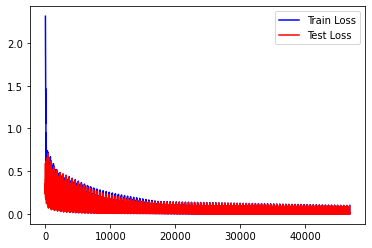

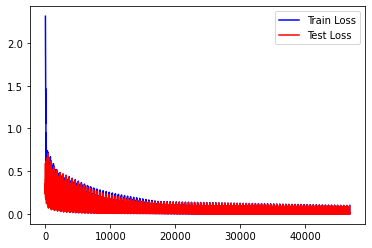

In [17]:
fig = plt.figure()
plt.plot(train_loss_list, color='blue')
plt.plot(test_loss_list, color='red')
plt.legend(['Train Loss', 'Test Loss'])
fig